In [ ]:
!pip install sentence-transformers

     |████████████████████████████████| 81kB 4.5MB/s 
     |████████████████████████████████| 2.1MB 8.7MB/s 
     |████████████████████████████████| 1.2MB 27.5MB/s 
     |████████████████████████████████| 901kB 37.5MB/s 
     |████████████████████████████████| 3.3MB 43.8MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.0-cp37-none-any.whl size=119615 sha256=57ba534ccfdb771db618fb80a18c5a5afb486abc1eb5da189d644e3b7b37013a
  Stored in directory: /root/.cache/pip/wheels/84/cb/21/1066bff3027215c760ca14a198f698bca8fccb92e33e2327eb
Successfully built sentence-transformers


In [ ]:
import re
import os
import csv
import sys
import string
import random

import math
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler 

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.utils
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sentence_transformers import SentenceTransformer
import seaborn as sns
import statistics
from tqdm.notebook import tqdm
from collections import namedtuple
from typing import List, Tuple, Dict, Set, Union

import gensim
import gensim.downloader as api

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
sys.path.insert(0,"/content/drive/My Drive/ML_proj/helpers")
import embedding_utils as e_utils
import lyric_utils as l_utils
import nn_utils as nn_utils
import cnn_utils as cnn_utils

In [ ]:
## Large (14 Artist) Dataset
# artists = ['Kendrick Lamar', 'Eminem', 'DaBaby', 'RiFF RAFF', 'Lil Baby', 'Travis Scott', 'Jadakiss', 'Tory Lanez', 'Kanye West', 'Post Malone', 'Drake', 'Nicki Minaj', 'Cardi B', 'The Weeknd']

## Small (8 Artist) Dataset
artists = ['Eminem', 'DaBaby', 'RiFF RAFF', 'Lil Baby', 'Travis Scott', 'Drake', 'Nicki Minaj', 'The Weeknd']

art2idx = {}
idx2art = {}
n_artists = 0

for artist in artists:

  art2idx[artist] = n_artists
  idx2art[n_artists] = artist
  n_artists += 1

train_df = pd.read_csv('/content/drive/My Drive/ML_proj/train_df_large_long1.csv')
val_df = pd.read_csv('/content/drive/My Drive/ML_proj/val_df_large_long1.csv')
test_df = pd.read_csv('/content/drive/My Drive/ML_proj/test_df_large_long1.csv')

train_df = train_df[train_df['Artist'].isin(artists)]
val_df = val_df[val_df['Artist'].isin(artists)]
test_df = test_df[test_df['Artist'].isin(artists)]

In [ ]:
print(str(n_artists) + " artists")
print(train_df)
print(val_df)
print(test_df)

8 artists
       Unnamed: 0  ...      Artist
1481         2402  ...      Eminem
1482         1836  ...      Eminem
1483        13507  ...      Eminem
1484         2302  ...      Eminem
1485         1125  ...      Eminem
...           ...  ...         ...
13134       20436  ...  The Weeknd
13135       20741  ...  The Weeknd
13136       20953  ...  The Weeknd
13137       20176  ...  The Weeknd
13138       20425  ...  The Weeknd

[7507 rows x 3 columns]
      Unnamed: 0                                              Lyric      Artist
150         2485                     Cinderella Man, Cinderella Man      Eminem
151        13481  Their mother wasn't raped, I ate her pussy whi...      Eminem
152        14130  O-oh, o-oh, bitches hoppin' in my Tahoe Got on...      Eminem
153         1777  With a potato peeler And mushed her face into ...      Eminem
154         1653  I know what it was like, I was there once Sing...      Eminem
...          ...                                                .

In [ ]:
def words2charindices(sents):
    """ Convert list of sentences of words into list of list of list of character indices.
    @param sents (list[list[str]]): sentence(s) in words
    @return word_ids (list[list[list[int]]]): sentence(s) in indices
    """
    results = []
    for s in sents:
        y = []
        for w in s:
            x = [1]
            for c in list(w):
                if c in char2id:
                    x.append(char2id[c])
                else:
                    x.append(char2id['<unk>'])
            x.append(2)
            y.append(x)
        results.append(y)

    return results

def to_input_tensor_char(sents, device,max_sent_len):
    """ Convert list of sentences (words) into tensor with necessary padding for
    shorter sentences.

    @param sents (List[List[str]]): list of sentences (words)
    @param device: device on which to load the tensor, i.e. CPU or GPU

    @returns sents_var: tensor of (max_sentence_length, batch_size, max_word_length)
    """
    char_ids = words2charindices(sents)
    chars_t = pad_sents_char(char_ids, char2id['<pad>'],max_sent_len)
    chars_var = torch.tensor(chars_t, dtype=torch.long,device=device)
    chars_var = chars_var.permute(1,0,2)
    chars_var = chars_var.contiguous()

    return chars_var
    

def pad_sents_char(sents, char_pad_token,max_sent_length=150):
    """ Pad list of sentences according to the longest sentence in the batch and max_word_length.
    @param sents (list[list[list[int]]]): list of sentences, result of `words2charindices()`
        from `vocab.py`
    @param char_pad_token (int): index of the character-padding token
    @returns sents_padded (list[list[list[int]]]): list of sentences where sentences/words shorter
        than the max length sentence/word are padded out with the appropriate pad token, such that
        each sentence in the batch now has same number of words and each word has an equal
        number of characters
        Output shape: (batch_size, max_sentence_length, max_word_length)
    """
    max_word_length = 21
    sents_padded = []

    max_len = max(len(s) for s in sents)
    batch_size = len(sents)

    for s in sents:
        s_padded = []
        for w in s:
            w_padded = []
            for c in w:
                w_padded.append(c)
                if len(w_padded) >= max_word_length:
                    break
            w_diff = max_word_length - len(w_padded)
            for i in range(w_diff):
                w_padded.append(char_pad_token)
            s_padded.append(w_padded)
            if len(s_padded) >= max_sent_length:
                break
        s_diff = max_sent_length - len(s_padded)
        for i in range(s_diff):
            s_padded.append( max_word_length*[char_pad_token] )
        sents_padded.append(s_padded)
    return sents_padded

In [ ]:
class CNN(nn.Module):

  def __init__(self, char_embed_size,word_embed_size, kernel_size=5,padding=1):

    super(CNN, self).__init__()

    self.kernel_size = kernel_size
    self.pool = nn.MaxPool1d(3)
    self.conv_layer1 = nn.Conv1d(char_embed_size, word_embed_size, kernel_size, padding)
    self.conv_layer2 = nn.Conv1d(word_embed_size, word_embed_size, kernel_size, padding)
    self.relu = nn.ReLU()


  def forward(self, t):

    # xconv = self.conv_layer(t)
    # xconvout = torch.max(self.relu(xconv), dim=2)[0]

    xconv = self.conv_layer1(t)
    xconv = self.relu(xconv)
    xconv = self.pool(xconv)

    xconv = self.conv_layer2(xconv)
    xconvout = torch.max(self.relu(xconv), dim=2)[0]

    return xconvout

class Highway(nn.Module):

  def __init__(self, embed_size):

    super(Highway, self).__init__()

    self.proj_layer = nn.Linear(embed_size, embed_size, bias=True)
    self.gate_layer = nn.Linear(embed_size, embed_size, bias=True)

    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, t):

    xproj = self.relu( self.proj_layer(t) )
    xgate = self.sigmoid( self.gate_layer(t) )

    xhighway = (xgate * xproj) + ((1 - xgate) * t)

    return xhighway

In [ ]:
class ModelEmbeddings(nn.Module): 
  """
  Class that converts input words to their CNN-based embeddings.
  """
  def __init__(self, embed_size, vocab):
    """
    Init the Embedding layer for one language
    @param embed_size (int): Embedding size (dimensionality) for the output 
    @param vocab (VocabEntry): VocabEntry object. See vocab.py for documentation.
    """
    super(ModelEmbeddings, self).__init__()

    self.vocab = vocab
    self.size_of_vocab = len(self.vocab['char2id'])
    pad_token_idx = vocab['char2id']['<pad>']

    self.embed_size = embed_size
    self.char_embed_size = embed_size
    self.kernel_size = 3

    self.char_embeddings = nn.Embedding(self.size_of_vocab, self.char_embed_size,padding_idx=pad_token_idx)

    self.highway = Highway(self.embed_size)
    self.cnn = CNN(self.char_embed_size, self.embed_size, self.kernel_size)

    self.dropout = nn.Dropout(0.3)

  def forward(self, input_tensor):
    """
    Looks up character-based CNN embeddings for the words in a batch of sentences.
    @param input_tensor: Tensor of integers of shape (sentence_length, batch_size, max_word_length) where
        each integer is an index into the character vocabulary

    @param output: Tensor of shape (sentence_length, batch_size, embed_size), containing the 
        CNN-based embeddings for each word of the sentences in the batch
    """
    x_pad = input_tensor
    sent_length, batch_size, max_word_length = x_pad.shape
    x_emb = self.char_embeddings(input_tensor)

    x_resh = x_emb.permute(0,1,3,2)
    x_resh = x_resh.view(-1, self.char_embed_size, max_word_length)

    x_conv_out = self.cnn(x_resh)
    x_highway = self.highway(x_conv_out)        
    x_highway = x_highway.view(sent_length, batch_size, self.embed_size)

    x_word_embed = self.dropout(x_highway)
    return x_word_embed



In [ ]:
stopwords = []
lyrics = train_df['Lyric'].tolist() + val_df['Lyric'].tolist() + test_df['Lyric'].tolist()
# lyrics = [l_utils.string_process(str(lyric),stopwords,False) for lyric in lyrics]
# lyrics = [" ".join(lyric) for lyric in lyrics]

idx_lyrics = [(j,lyric) for j,lyric in enumerate(lyrics)]

In [ ]:
X_train = idx_lyrics[:train_df.shape[0]]
X_val = idx_lyrics[train_df.shape[0]:train_df.shape[0]+val_df.shape[0]]
X_test = idx_lyrics[train_df.shape[0]:train_df.shape[0]+val_df.shape[0]]

y_train = train_df['Artist'].to_list()
y_train = [art2idx[x] for x in y_train]
y_train = np.asarray(y_train)

y_val = val_df['Artist'].to_list()
y_val = [art2idx[x] for x in y_val]
y_val = np.asarray(y_val)

y_test = test_df['Artist'].to_list()
y_test = [art2idx[x] for x in y_test]
y_test = np.asarray(y_test)

print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))
print(len(X_test))
print(len(y_test))

7507
7507
1200
1200
1200
1200


In [ ]:
# sbert = SentenceTransformer('stsb-roberta-base')

In [ ]:
# #BUILD SBERT EMBEDS
# print('Building SBert Embeds')

# l_text = list(map(l_utils.myMap, lyrics))
# l_embeds = sbert.encode(l_text)
# l_embeds = np.array(l_embeds)
# l_embeds = torch.from_numpy(l_embeds)
# print(l_embeds.shape)

Building SBert Embeds
torch.Size([9907, 768])


In [ ]:
# # ###BUILD BoW EMBEDS
# print('Building BoW Embeds')

# doc_embed_size = 768
# stopwords = []
# n_train = train_df.shape[0]

# corpus = []

# for i,lyric in enumerate(lyrics):
#   # lyric = str(line[1])
#   proc = l_utils.string_process(lyric,stopwords,False)
#   corpus.append( proc )

# M_embeddings, word2Ind = e_utils.compute_embedding_matrix(corpus)
# print(M_embeddings.shape)

# l_embeds = e_utils.reduce_to_k_dim(M_embeddings, doc_embed_size,n_train)
# l_embeds = torch.Tensor(l_embeds)

Building BoW Embeds
(9907, 20340)
Running Truncated SVD over 9907 lyrics...
Fit using only first 7507 (training) examples
Done.


In [ ]:
##BUILD doc2vec EMBEDS
print('Building doc2vec Embeds')

def tagged_document(list_of_list_of_words,targets=None):
  for i, list_of_words in enumerate(list_of_list_of_words):
    if targets is not None:
      yield gensim.models.doc2vec.TaggedDocument(list_of_words, [int(targets[i])])
    else:
      yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

stopwords = []
data =  list(train_df['Lyric'].items())
data = [l_utils.string_process(str(lyric[1]),stopwords,False) for lyric in data]

targets = y_train
data_for_training = list(tagged_document(data,targets))

model = gensim.models.doc2vec.Doc2Vec(vector_size=768, min_count=0, epochs=10)
model.build_vocab(data_for_training)
model.train(data_for_training, total_examples=model.corpus_count, epochs=model.epochs)

lines = [l_utils.string_process(str(lyric),stopwords,False) for lyric in lyrics]

embeddings = []
for i, line in enumerate(lines):
  
  vec = model.infer_vector(lines[i])
  embeddings.append(vec)

l_embeds = np.array(embeddings)
l_embeds = torch.Tensor(l_embeds)
print(l_embeds.shape)

['with', 'a', 'bottle', 'of', 'jack', 'two', 'grandkids', 'in', 'my', 'lap', 'babysittin', 'for', 'hailie', 'while', 'hailie', 's', 'out', 'gettin', 'smashed', '‘cause', 'every', 'time', 'i', 'go', 'to', 'try', 'to', 'leave', 'whoa', 'something', 'keeps', 'pullin', 'on', 'my', 'sleeve', 'whoa', 'i', 'don', 't', 'wanna', 'but', 'i', 'gotta', 'stay', 'whoa', 'these', 'drugs', 'really', 'got', 'a', 'hold', 'of', 'me', 'whoa', '‘cause', 'every', 'time', 'i', 'try', 'to', 'tell', 'em', 'no', 'no', 'they', 'won', 't', 'let', 'me', 'ever', 'let', 'em', 'go', 'go']
torch.Size([9907, 768])


In [ ]:
char_list = list("""ABCDEFGHIJKLMNOPQRSTUVWXYZ ’—‘abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]""")

char2id = dict() # Converts characters to integers
char2id['<pad>'] = 0
char2id['{'] = 1
char2id['}'] = 2
char2id['<unk>'] = 3
for i, c in enumerate(char_list):
    char2id[c] = len(char2id)
char_unk = char2id['<unk>']
start_of_word = char2id["{"]
end_of_word = char2id["}"]
assert start_of_word+1 == end_of_word

id2char = {v: k for k, v in char2id.items()}

In [ ]:
class TomNet(nn.Module):

    def __init__(self, embed_size, hidden_size, vocab, lookup, num_class, device, use_cnn = True, max_sent_len = 150, dropout_rate=0.2):
        """ Init TomNet Model.

        @param embed_size (int): Embedding size (dimensionality)
        @param hidden_size (int): Hidden Size (dimensionality)
        @param vocab (Vocab): Vocabulary object containing src and tgt languages
                              See vocab.py for documentation.
        @param dropout_rate (float): Dropout probability, for attention
        """
        super(TomNet, self).__init__()

        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        self.vocab = vocab
        self.device = device

        self.max_sent_len = max_sent_len
        self.use_cnn = use_cnn
        
        self.model_embeddings_source = ModelEmbeddings(embed_size, vocab)
        self.text_embeddings = nn.Embedding.from_pretrained(lookup)

        self.word_embed_size = embed_size

        if self.use_cnn:
            self.num_features = 768+self.hidden_size
        else:
            self.num_features = 768
        self.num_class = num_class

        self.n1 = 1024
        self.n2 = 1024
        self.n3 = 512

        proj_size = self.word_embed_size*self.max_sent_len
        self.cnn_proj = nn.Linear(proj_size, self.hidden_size)
        self.layer_1 = nn.Linear(self.num_features, self.n1)
        self.layer_2 = nn.Linear(self.n1, self.n2)
        self.layer_3 = nn.Linear(self.n2, self.n3)
        self.layer_out = nn.Linear(self.n3, self.num_class)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=self.dropout_rate)
        self.batchnormp = nn.BatchNorm1d(self.hidden_size)
        self.batchnorm1 = nn.BatchNorm1d(self.n1)
        self.batchnorm2 = nn.BatchNorm1d(self.n2)
        self.batchnorm3 = nn.BatchNorm1d(self.n3)

    def forward(self, source):
        """ Take a mini-batch of source sentences, compute scores
         under the language models learned by the TomNet system.

        @param source (List[List[str]]): list of source sentence tokens

        @returns scores (Tensor): a variable/tensor of shape (b, ). Here b = batch size.
        """
        text = []
        text_ids = []
        for s in source:
            text_ids.append(s[0])
            text.append(s[1])
        if self.use_cnn:
            
            source_padded_chars = to_input_tensor_char(text,self.device,self.max_sent_len)
            X = self.model_embeddings_source(source_padded_chars)

            X = X.reshape(-1, X.shape[1]).permute(1,0)
            X = self.cnn_proj(X)
            X = self.batchnormp(X)
            X = self.relu(X)
        
            input = torch.tensor(text_ids, dtype=torch.long, device=device)
            sent_embeds = self.text_embeddings(input)

            x = torch.cat((X,sent_embeds),1)

        else:
            input = torch.tensor(text_ids, dtype=torch.long, device=device)
            x = self.text_embeddings(input)

        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)

        return x



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 0.001
NUM_CLASSES = n_artists

vocab = {}
vocab['char2id'] = char2id
vocab['id2char'] = id2char

word_embed_size = e_char = 50
hidden_size = 512
use_cnn = False
max_sent_len = 120

nn_model = TomNet(word_embed_size,hidden_size,vocab,l_embeds,n_artists,device,use_cnn,max_sent_len)
nn_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn_model.parameters(), lr=LEARNING_RATE)
print(nn_model)

cuda:0
TomNet(
  (model_embeddings_source): ModelEmbeddings(
    (char_embeddings): Embedding(100, 50, padding_idx=0)
    (highway): Highway(
      (proj_layer): Linear(in_features=50, out_features=50, bias=True)
      (gate_layer): Linear(in_features=50, out_features=50, bias=True)
      (relu): ReLU()
      (sigmoid): Sigmoid()
    )
    (cnn): CNN(
      (pool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (conv_layer1): Conv1d(50, 50, kernel_size=(3,), stride=(1,))
      (conv_layer2): Conv1d(50, 50, kernel_size=(3,), stride=(1,))
      (relu): ReLU()
    )
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (text_embeddings): Embedding(9907, 768)
  (cnn_proj): Linear(in_features=6000, out_features=512, bias=True)
  (layer_1): Linear(in_features=768, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=1024, bias=True)
  (layer_3): Linear(in_features=1024, out_features=512, bias=True)
  (layer_out): Linear(in_features=5

In [ ]:
accuracy_stats = {'train': [],"val": []}
loss_stats = {'train': [], "val": []}

train_data = list(zip(X_train, y_train))
val_data = list(zip(X_val, y_val))

fp = "/content/drive/My Drive/ML_proj/saved_models/lyric_small_cnn_200"

best_val_acc = 0.0
print("Begin training TomNet.")
for e in tqdm(range(1, EPOCHS+1)):
    
  # TRAINING
  nn_model.train()
  
  train_epoch_loss = 0
  train_epoch_acc = 0
  count_train = 0
  for X_train_batch, y_train_batch in nn_utils.batch_iter(train_data, batch_size=BATCH_SIZE, shuffle=True):

    y_train_batch = torch.tensor(y_train_batch, dtype=torch.long).to(device)
    optimizer.zero_grad()
    
    y_train_pred = nn_model(X_train_batch)

    train_loss = criterion(y_train_pred, y_train_batch)
    train_acc = nn_utils.multi_acc(y_train_pred, y_train_batch)
    
    train_loss.backward()
    optimizer.step()
    
    train_epoch_loss += train_loss.item()
    train_epoch_acc += train_acc.item()
    count_train += 1

  # VALIDATION
  with torch.no_grad():
        
    nn_model.eval()

    val_epoch_loss = 0
    val_epoch_acc = 0
    count_val = 0
    for X_val_batch, y_val_batch in val_data:

      y_val_pred = nn_model([X_val_batch])
      y_val_batch = torch.tensor([y_val_batch]).to(device)         
      val_loss = criterion(y_val_pred, y_val_batch)
      val_acc = nn_utils.multi_acc(y_val_pred, y_val_batch)
      
      val_epoch_loss += val_loss.item()
      val_epoch_acc += val_acc.item()
      count_val += 1
            
  loss_stats['train'].append(train_epoch_loss/count_train)
  loss_stats['val'].append(val_epoch_loss/count_val)
  accuracy_stats['train'].append(train_epoch_acc/count_train)
  accuracy_stats['val'].append(val_epoch_acc/count_val)

  val_acc = val_epoch_acc/count_val
  if val_acc > best_val_acc and e > 20:
    best_val_acc = val_acc
    torch.save(nn_model.state_dict(), fp+"_best")
                            
  print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/count_train:.5f} | Train Acc: {train_epoch_acc/count_train:.3f} | Val Loss: {val_epoch_loss/count_val:.5f} | Val Acc: {val_epoch_acc/count_val:.3f}')
  


Begin training TomNet.


Epoch 001: | Train Loss: 0.85705 | Train Acc: 70.562 | Val Loss: 0.98543 | Val Acc: 67.250
Epoch 002: | Train Loss: 0.69481 | Train Acc: 76.379 | Val Loss: 1.07591 | Val Acc: 65.917
Epoch 003: | Train Loss: 0.63438 | Train Acc: 77.970 | Val Loss: 1.02768 | Val Acc: 66.250
Epoch 004: | Train Loss: 0.59428 | Train Acc: 79.798 | Val Loss: 1.20650 | Val Acc: 64.417
Epoch 005: | Train Loss: 0.56655 | Train Acc: 80.381 | Val Loss: 1.01180 | Val Acc: 67.833
Epoch 006: | Train Loss: 0.53037 | Train Acc: 81.102 | Val Loss: 1.07311 | Val Acc: 65.167
Epoch 007: | Train Loss: 0.51432 | Train Acc: 82.374 | Val Loss: 1.04301 | Val Acc: 66.833
Epoch 008: | Train Loss: 0.49055 | Train Acc: 82.857 | Val Loss: 1.08833 | Val Acc: 65.167
Epoch 009: | Train Loss: 0.47590 | Train Acc: 82.998 | Val Loss: 1.09295 | Val Acc: 66.250
Epoch 010: | Train Loss: 0.44981 | Train Acc: 84.619 | Val Loss: 1.04943 | Val Acc: 67.583
Epoch 011: | Train Loss: 0.41828 | Train Acc: 85.632 | Val Loss: 1.09593 | Val Acc: 67.750

In [ ]:
# Save model:
# filepath = "/content/drive/My Drive/ML_proj/saved_models/lyric_small_cnn_200"
filepath = fp
torch.save(nn_model.state_dict(), filepath)

# Later to restore:
# filepath = fp+"_best"
# nn_model.load_state_dict(torch.load(filepath))

In [ ]:
test_data = list(zip(X_test, y_test))

y_pred_list = []
y_probs_list = []
found = 0
top_n = 3

with torch.no_grad():
    nn_model.eval()
    for X_batch, y_batch in test_data:
        y_test_pred = nn_model([X_batch])

        probs = y_test_pred.tolist()[0]
        sm = torch.softmax(torch.tensor(probs),0).tolist()
        y_probs_list.append(sm)
        
        s = list( zip( probs, art2idx.keys() ) )
        
        s.sort(reverse=True)
        top = s[0:top_n]
        guesses = [i[1] for i in top]
        ans = idx2art[y_batch]

        if ans in guesses:
            found += 1
        
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
top_n_sc = found/len(X_test)

n_artists = 8

Test Results
-------------
Accuracy: 0.6825
ROC AUC: 0.9348845238095238
Avg f1: 0.6828473403133768
Top 3 score: 0.8858333333333334
Metrics:
              precision    recall  f1-score   support

      Eminem      0.663     0.813     0.731       150
      DaBaby      0.711     0.707     0.709       150
   RiFF RAFF      0.864     0.507     0.639       150
    Lil Baby      0.841     0.633     0.722       150
Travis Scott      0.720     0.753     0.736       150
       Drake      0.549     0.593     0.571       150
 Nicki Minaj      0.552     0.740     0.632       150
  The Weeknd      0.733     0.713     0.723       150

    accuracy                          0.682      1200
   macro avg      0.704     0.682     0.683      1200
weighted avg      0.704     0.682     0.683      1200



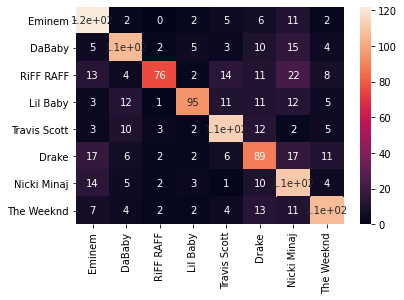

In [ ]:
print('n_artists = ' + str(n_artists) + '\n')
print('Test Results')
print('-------------')

score = accuracy_score(y_pred_list,y_test)
print('Accuracy: ' + str(score))

print('ROC AUC: ' + str(roc_auc_score(y_test, y_probs_list, multi_class='ovr')))

f1 = f1_score(y_test, y_pred_list, average='macro')
print('Avg f1: ' + str(f1))

print('Top ' + str(top_n) + " score: " + str(top_n_sc))

print('Metrics:')
test_met = metrics.classification_report(y_test, y_pred_list, target_names=artists, digits=3)
print(test_met)

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list))
x_axis_labels = y_axis_labels = list(art2idx.keys())
sns.heatmap(confusion_matrix_df, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)

Text(0.5, 1.0, 'Train-Val Accuracy/Epoch')

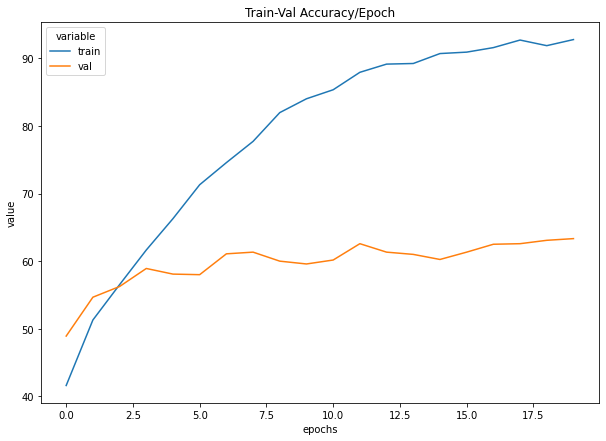

In [ ]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes).set_title('Train-Val Accuracy/Epoch')
# sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')



In [ ]:
import netron

for X_train_batch, y_train_batch in batch_iter(train_data, batch_size=BATCH_SIZE, shuffle=True):
  y_train_batch = torch.tensor(y_train_batch, dtype=torch.long).to(device)
  optimizer.zero_grad()

  y_train_pred = nn_model(X_train_batch)
  break

input_names = ['Document Embedding (Batch)']
output_names = ['Class Probabilities']
torch.onnx.export(nn_model, X_train_batch, 'cnn_v2.onnx', input_names=input_names, output_names=output_names)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
